## Data Preperation 

* Many of the columns are just repeated the values, changed the column data type to categorical data type in this way the the rows are just references to these values.

* Using the Parquet file type with PyArrow (or fast Parquet) . The parquet file encodes our data types and it is also lighter and much faster to load. Pandas will now use PyArrow in the backend  now the whole BHB data set can be loaded and manipulated easily.

PyArrow
```Shell
conda install -c conda-forge pyarrow
```

In [2]:
import os
import pandas as pd
from pathlib import Path

cpu_model = !sed '5!d' /proc/cpuinfo
n_cpus=os.cpu_count()

print(cpu_model, '\n CPUS:', n_cpus)

data_folder = Path(r'D:\iorio+22_Zenodo_repository_V2\iorio+22_Zenodo_repository_V2\data_from_simulations\simulation_F')
data_path = Path(data_folder,'BHBHm.csv')
df = pd.read_csv(Path(data_folder,'BHBHm.csv'))



["'sed' is not recognized as an internal or external command,", 'operable program or batch file.'] 
 CPUS: 16


In [3]:
df.columns
df

,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
...,...,...,...,...,...
158996,10.57255,10.394180,0.0300,3.0,0.983129
158997,10.41027,9.384505,0.0300,3.0,0.901466
158998,7.55398,6.708311,0.0300,5.0,0.888050
158999,10.57255,10.394180,0.0300,5.0,0.983129


### This  is innefficent as we don't actually need all of these columns

In [4]:
# Select relevant columns
df = df[["Mass_0", "Mass_1", "Z", "alpha"]]

# Convert 'alpha' to float
df['alpha'] = df['alpha'].astype(float)

# Swap masses if Mass_1 > Mass_0
df.loc[df['Mass_1'] > df['Mass_0'], ['Mass_0', 'Mass_1']] = df.loc[df['Mass_1'] > df['Mass_0'], ['Mass_1', 'Mass_0']].values

# Calculate mass ratio q
df['q'] = df['Mass_1'] / df['Mass_0']

#drop the qs that equal to 1
df = df[df['q'] != 1]
print(df[df['q'] == 0])


#sth silly but urgent
# df[['Mass_1', 'q']] = df[['q', 'Mass_1']].values

# Save to CSV
df.to_csv(data_path, index=False)



C:\Users\Asus\AppData\Local\Temp\ipykernel_12072\2415895564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['alpha'] = df['alpha'].astype(float)


Empty DataFrame
Columns: [Mass_0, Mass_1, Z, alpha, q]
Index: []


### Better yet to not load the extra columns at all

In [5]:
df=pd.read_csv(data_path, usecols = ['Mass_0','q','Z','alpha','Mass_1'])
df

,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
...,...,...,...,...,...
158996,10.57255,10.394180,0.0300,3.0,0.983129
158997,10.41027,9.384505,0.0300,3.0,0.901466
158998,7.55398,6.708311,0.0300,5.0,0.888050
158999,10.57255,10.394180,0.0300,5.0,0.983129


Make the repetitive columns categorical

In [6]:
df['alpha'] = df.alpha.astype('category')
df['Z'] = df.Z.astype('category')
df.to_parquet('BHBHm.pq')

In [7]:
old_size=os.stat(data_path).st_size
new_size=os.stat('BHBHm.pq').st_size
print("file now", round((new_size/old_size)*100), '% of the original size')

file now 35 % of the original size


## Reading Parquet Files
```Python
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('BHNSm.pq') 
first_ten_rows = next(pf.iter_batches(batch_size = 30)) 
df = pa.Table.from_batches([first_ten_rows]).to_pandas() 
df
```


In [8]:
pd.read_parquet('BHBHm.pq')


,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
...,...,...,...,...,...
158996,10.57255,10.394180,0.0300,3.0,0.983129
158997,10.41027,9.384505,0.0300,3.0,0.901466
158998,7.55398,6.708311,0.0300,5.0,0.888050
158999,10.57255,10.394180,0.0300,5.0,0.983129


In [9]:
def read_rows(file, nrows=10, skiprows=1):  
    from pyarrow.parquet import ParquetFile
    import pyarrow as pa 
    pf = ParquetFile(file) 
    batch_list=list(pf.iter_batches(batch_size = nrows))
    nbatch=len(batch_list)
    nskip=int(skiprows/nrows)
    df = pa.Table.from_batches([batch_list[nskip]]).to_pandas()
    #could write something to open up batches either side and make new df
    #not teh most efficent
    #rounds to closed batch
    return df

read_rows('BHBHm.pq')

,Mass_0,Mass_1,Z,alpha,q
0,17.80632,15.805690,0.0001,0.5,0.887645
1,33.24870,25.701310,0.0001,0.5,0.773002
2,24.53676,20.099740,0.0001,0.5,0.819168
3,34.41521,25.073250,0.0001,0.5,0.728551
4,18.25818,7.264607,0.0001,0.5,0.397882
5,26.64688,14.374020,0.0001,0.5,0.539426
6,16.52531,6.289704,0.0001,0.5,0.380610
7,15.85697,14.084660,0.0001,0.5,0.888231
8,21.75281,18.246350,0.0001,0.5,0.838804
9,40.83927,36.232790,0.0001,0.5,0.887205


In [10]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('BHBHm.pq') 
#for all rows
df = pf.read().to_pandas()
#first_ten_rows = next(pf.iter_batches(batch_size = 900)) 
#df = pa.Table.from_batches([first_ten_rows]).to_pandas() 
df

#print max of alpha
df.q.max()



0.9999929383212476

           Mass_0     Mass_1       Z  alpha         q
0      -31.374224  15.805690  0.0001    0.5  0.412793
1      -14.723908  25.701310  0.0001    0.5  0.254582
2      -23.430758  20.099740  0.0001    0.5  0.310148
3      -13.639354  25.073250  0.0001    0.5  0.206869
4      -30.789373   7.264607  0.0001    0.5 -0.088003
...           ...        ...     ...    ...       ...
158996 -42.485907  10.394180  0.0300    3.0  0.721868
158997 -42.789526   9.384505  0.0300    3.0  0.438583
158998 -48.814770   6.708311  0.0300    5.0  0.413516
158999 -42.485907  10.394180  0.0300    5.0  0.721868
159000 -42.789526   9.384505  0.0300    5.0  0.438583

[159001 rows x 5 columns]


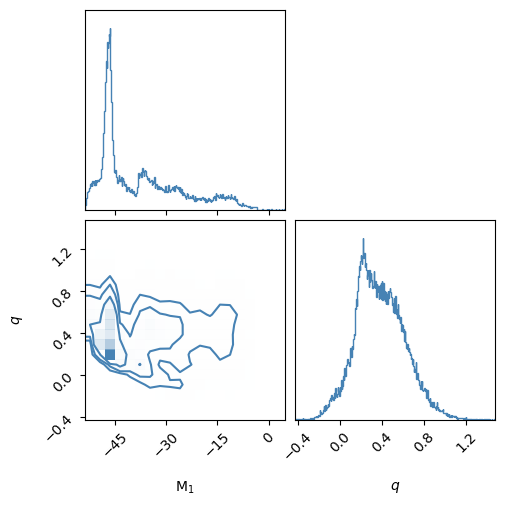

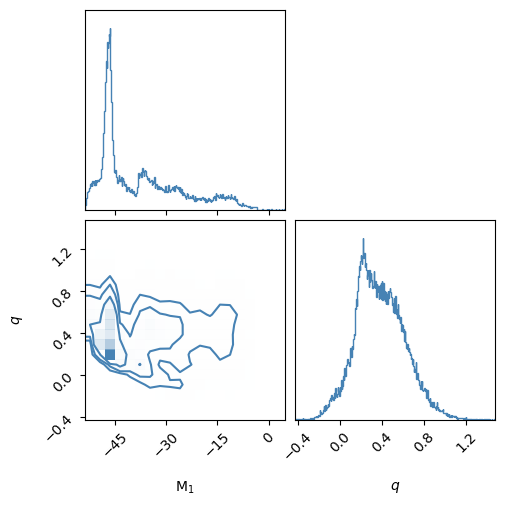

In [ ]:
import numpy as np
import pandas as pd
from scipy.special import erfinv
from figaro.transform import transform_to_probit, transform_from_probit

# dataframew
# df = pd.DataFrame([Mass_0, Mass_1])


# Define bounds
bounds = np.array([[0.0, 100.0], [0.0, 1.]])  

data_array = df[['Mass_0','q']].values

transformed_data = transform_to_probit(data_array, bounds)

transformed_df = df 

transformed_df['Mass_0'] = transformed_data[:,0]
transformed_df['q'] = transformed_data[:,1]

# max of transformed_df['q']



# Display the transformed DataFrame
print(transformed_df)

from corner import corner
corner(transformed_data, color = 'steelblue', hist_kwargs={'density':True, 'label': '$\\mathrm{Probit}$'}, hist_bin_factor=int(np.sqrt(len(transformed_data)))/20, labels = ['$\\mathrm{M}_1$', '$q$'], plot_density = True, no_fill_contours = True, plot_datapoints = False)
#ss = transform_from_probit(transformed_data, bounds)

In [14]:
#spliting the file into 3 parts for train test and validation
from sklearn.model_selection import train_test_split
#df=pd.read_parquet('BHBHm.pq')
train, test = train_test_split(transformed_df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.2, random_state=42)
train.to_parquet('train.pq')
test.to_parquet('test.pq')
valid.to_parquet('valid.pq')


## Building a Mock set of samples
We want to see if the NF follows the pattern

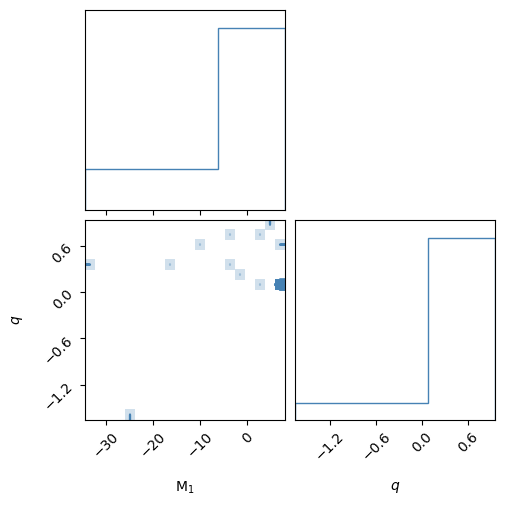

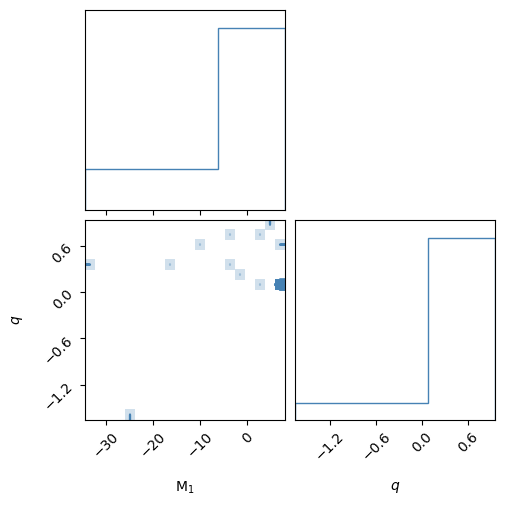

In [24]:
import numpy as np
import pandas as pd
from corner import corner

# Parameters
num_samples = len(transformed_df)  # Size of the dataset
alpha_values = [0.5, 1, 1.5, 1.7, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # Alpha values
Z = 0.001  # Constant Z value

# Define the weights for each alpha to create more data for larger alpha
alpha_weights = np.array(alpha_values) / sum(alpha_values)  # Normalize weights
samples_per_alpha = (alpha_weights * num_samples).astype(int)  # Samples per alpha

# Generate mock data
mock_data = []
for alpha, num_alpha_samples in zip(alpha_values, samples_per_alpha):
    for _ in range(num_alpha_samples):
        # Generate skewed data for Mass_0 and q based on alpha
        mass_0 = np.random.beta(alpha, 1) * (60 - 5) + 5  # Skewed distribution scaled to [5, 60]
        q = np.random.beta(alpha, 1)  # Skewed distribution scaled to [0, 1]
        
        # Append the generated sample
        mock_data.append([mass_0, q, Z, alpha])

# Convert to DataFrame
mock_df = pd.DataFrame(mock_data, columns=['Mass_0', 'q', 'Z', 'alpha'])

# Define bounds
bounds = np.array([[0.0, 100.0], [0.0, 1.0]])  

# Transform data using probit function
data_array = mock_df[['Mass_0', 'q']].values
transformed_data = transform_to_probit(data_array, bounds)

# Replace this with your intended DataFrame creation or transformation
transformed_df = pd.DataFrame(transformed_data, columns=['Mass_0', 'q'])
transformed_df['alpha'] = mock_df['alpha'].values  # Add alpha column for reference

# Visualize using corner plot
corner(
    transformed_data,
    color='steelblue',
    hist_kwargs={'density': True, 'label': '$\\mathrm{Probit}$'},
    hist_bin_factor=int(np.sqrt(len(transformed_data))) / 20,
    labels=['$\\mathrm{M}_1$', '$q$'],
    plot_density=True,
    no_fill_contours=True,
    plot_datapoints=False,
)

# Save the transformed data (optional)
mock_df.to_parquet('mock_data_with_alpha_dependency.parquet', index=False)


In [19]:
mock_df

,Mass_0,q,Z,alpha
0,47.593895,0.572994,0.001,0.5
1,13.929555,0.764299,0.001,0.5
2,32.462029,0.043562,0.001,0.5
3,18.652528,0.028808,0.001,0.5
4,40.318368,0.005471,0.001,0.5
...,...,...,...,...
158990,55.083672,0.937026,0.001,10.0
158991,55.952558,0.872854,0.001,10.0
158992,59.463900,0.965964,0.001,10.0
158993,47.721729,0.939280,0.001,10.0


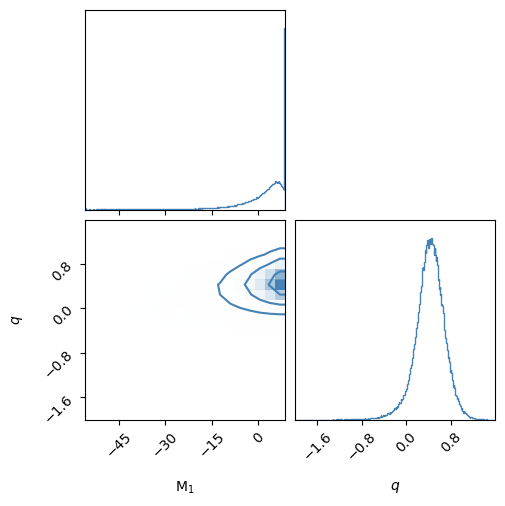

In [20]:
#spliting the file into 3 parts for train test and validation
from sklearn.model_selection import train_test_split
#df=pd.read_parquet('BHBHm.pq')
train, test = train_test_split(transformed_df, test_size=0.2, random_state=42)
train, valid = train_test_split(train, test_size=0.2, random_state=42)
train.to_parquet('train.pq')
test.to_parquet('test.pq')
valid.to_parquet('valid.pq')


KeyboardInterrupt: 